<a href="https://colab.research.google.com/github/AvantiShri/dueling_init/blob/master/DuelingInit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [29]:
!pip install simdna
!pip install keras-genomics

In [51]:
!rm *.fa *.simdata *.txt
!densityMotifSimulation.py --prefix pos --motifNames GATA_disc1 --mean-motifs 1 --min-motifs 1 --max-motifs 3 --rc-prob 0.5 --zero-prob 0.2 --numSeqs 1000 --seqLength 400 --seed 1234
!emptyBackground.py --prefix neg --seqLength 400 --numSeqs 1000

In [52]:
from glob import glob
import numpy as np
import sklearn
import sklearn.model_selection

ltr = {
    'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1]
}

def onehot_encode(seqs):
  return np.array([ [ltr[x] for x in seq] for seq in seqs])

def read_fasta(file):
  return [x.rstrip() for i,x in enumerate(open(file)) if i%2==1]

pos_seqs = read_fasta(glob("DensityEmbedding_prefix-pos*.fa")[0])
neg_seqs = read_fasta(glob("EmptyBackground_prefix-neg*.fa")[0])

all_onehot = onehot_encode(pos_seqs+neg_seqs)
all_labels = np.array([[1] for x in pos_seqs]+[[0] for x in neg_seqs])

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    all_onehot, all_labels, test_size=0.2, random_state=1234)

In [56]:
import tensorflow as tf
import numpy as np
from keras_genomics.layers.convolutional import RevCompConv1D
from sklearn.metrics import roc_auc_score


class RevCompSumPool(keras.engine.Layer):
    def __init__(self, **kwargs): 
        super(RevCompSumPool, self).__init__(**kwargs)

    def build(self, input_shape):
        self.num_input_chan = input_shape[2]
        super(RevCompSumPool, self).build(input_shape)

    def call(self, inputs): 
        #divide by sqrt 2 for variance preservation
        inputs = (inputs[:,:,:int(self.num_input_chan/2)] +
                  inputs[:,:,int(self.num_input_chan/2):][:,::-1,::-1])/(1.41421356237)
        return inputs
      
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], int(input_shape[2]/2))


def set_seed(seed):
  np.random.seed(seed)
  tf.set_random_seed(seed)


def make_standard_model(filter_width, filt_per_layer, num_layers):
  model = keras.models.Sequential()
  model.add(keras.layers.Conv1D(filters=filt_per_layer,
                                kernel_size=filter_width,
                                input_shape=X_train.shape[1:],
                                activation="relu",
                                kernel_initializer="he_normal"))
  for i in range(1,num_layers):
    model.add(keras.layers.Conv1D(filters=filt_per_layer,
                                kernel_size=filter_width,
                                activation="relu",
                                kernel_initializer="he_normal"))
  model.add(keras.layers.GlobalAveragePooling1D())
  model.add(keras.layers.Dense(1, activation="sigmoid"))
  return model


def make_rcconv_model(filter_width, filt_per_layer, num_layers):
  model = keras.models.Sequential()
  model.add(RevCompConv1D(filters=filt_per_layer,
                                       kernel_size=filter_width,
                                       input_shape=X_train.shape[1:],
                                       activation="relu",
                                       kernel_initializer="he_normal"))
  for i in range(1,num_layers):
    model.add(RevCompConv1D(filters=filt_per_layer,
                                         kernel_size=filter_width,
                                         activation="relu",
                                         kernel_initializer="he_normal"))
  model.add(keras.layers.GlobalAveragePooling1D())
  model.add(keras.layers.Dense(1, activation="sigmoid"))
  return model


def make_rcfull_model(filter_width, filt_per_layer, num_layers):
  model = keras.models.Sequential()
  model.add(RevCompConv1D(filters=filt_per_layer,
                                       kernel_size=filter_width,
                                       input_shape=X_train.shape[1:],
                                       activation="relu",
                                       kernel_initializer="he_normal"))
  for i in range(1,num_layers):
    model.add(RevCompConv1D(filters=filt_per_layer,
                                         kernel_size=filter_width,
                                         activation="relu",
                                         kernel_initializer="he_normal"))
  model.add(RevCompSumPool())
  model.add(keras.layers.GlobalAveragePooling1D())
  model.add(keras.layers.Dense(1, activation="sigmoid"))
  return model


def train_model(modelcreator, seed, patience):
  set_seed(seed)
  model = modelcreator()
  early_stopping_callback = keras.callbacks.EarlyStopping(
                              patience=patience, restore_best_weights=True)
  model.compile(optimizer="adam", loss="binary_crossentropy",
                metrics=["accuracy"])
  history = model.fit(X_train, y_train,
            validation_data=(X_test, y_test), epochs=100,
            callbacks=[early_stopping_callback])
  model.set_weights(early_stopping_callback.best_weights)
  y_test_preds = model.predict(X_test)
  return roc_auc_score(y_true=y_test, y_score=y_test_preds)


def train_many_models(modelcreator, num_seeds, patience):
  aucs = []
  for seednum in range(num_seeds):
    seed = seednum*100
    print("Seed:",seed)
    auc = train_model(modelcreator, seed, patience=patience)
    aucs.append(auc)
    print("AUC:",auc)
  print("AUCS:",aucs)
  return aucs

In [57]:
archname_and_factory = [    
('standard_width15_10filt_3layer', lambda: make_standard_model(filter_width=15, filt_per_layer=20, num_layers=3)),
('standard_width7_10filt_3layer', lambda: make_standard_model(filter_width=7, filt_per_layer=20, num_layers=3)),
]

archname_to_aucs = {}
for archname, factory in archname_and_factory:
  print(archname)
  aucs = train_many_models(factory, num_seeds=5, patience=15)
  archname_to_aucs[archname] = aucs


standard_width15_10filt_3layer
Seed: 0
Train on 1600 samples, validate on 400 samples
Epoch 1/100
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6994 - accuracy: 0.4994 - val_loss: 0.6934 - val_accuracy: 0.5050
Epoch 2/100
1600/1600 [==============================] - 0s 231us/step - loss: 0.6947 - accuracy: 0.5044 - val_loss: 0.6932 - val_accuracy: 0.5050
Epoch 3/100
1600/1600 [==============================] - 0s 223us/step - loss: 0.6937 - accuracy: 0.4844 - val_loss: 0.6930 - val_accuracy: 0.5050
Epoch 4/100
1600/1600 [==============================] - 0s 230us/step - loss: 0.6933 - accuracy: 0.5025 - val_loss: 0.6930 - val_accuracy: 0.5025
Epoch 5/100
1600/1600 [==============================] - 0s 225us/step - loss: 0.6930 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4950
Epoch 6/100
1600/1600 [==============================] - 0s 218us/step - loss: 0.6927 - accuracy: 0.5256 - val_loss: 0.6931 - val_accuracy: 0.4950
Epoch 7/100
1600/1600 [===========

In [59]:
for archname, aucs in archname_to_aucs.items():
  print(archname, aucs)

standard_width15_10filt_3layer [0.7229222922292229, 0.6551655165516552, 0.658965896589659, 0.8029802980298029, 0.6961446144614463]
standard_width7_10filt_3layer [0.7982298229822983, 0.8096809680968098, 0.8080558055805581, 0.8445344534453446, 0.8153565356535654]


Exploratory analysis

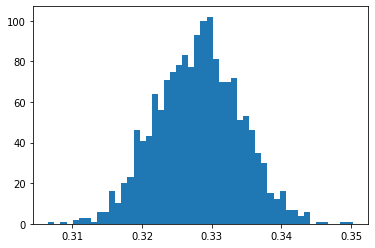

In [ ]:
from matplotlib import pyplot as plt
set_seed(100)
amodel = modarch1_factory()
init_preds = amodel.predict(X_train)
plt.hist(init_preds, bins=50)
plt.show()

In [16]:
!head -40 DensityEmbedding_prefix-pos*.simdata

seqName	sequence	embeddings
pos-synth0	AGCTTAATTTCGGTCGGATTCGACTGCTCGTCTATTATCTAAAGGGAGCGAGGAGTTTTTAGCACACTAATGCAATCGACCGTGTATTGCAGGTCGGTAGTTACTGATAAGGCTTACATTTTTGAACGAACGTAAATACGATTGACTAGATGAATTTTGGAGTTTTGCTTGCCTATCTTTGCTTCACTCCGAATACGATTTTGTTTACACATGGGCCCCTCATTCGCAACAGTTCACTTCAAAGAAAGATCTGAGGATGGGGATTTGCTGCGCAGTTGACAAGAGGTTTAAGTTGCGTGAATCGGAAGTCTAAAAAGTTGTGGGTATAAAAGCTACTCTGTTTATGATAATTGCAGTTTAGCCATGATTCTGACCATTGCCAGTAGATTGTAACTTCTAC	pos-102_GATA_disc1-ACTGATAAGG
pos-synth1	TTTTACTTGTGATCTCATAGAAGTGTCAATACAGGGTTATGATGGCCCTAGGAGAATATCCAACGATATCTCACTAGCGAATTAGTTGAATAGTAGCAAAAACATTTAGTTACGGGTTCATCATTAACCAACATTAACTTATTCAAATACGGCCACTTATATAACTTCAGAAGGATTTCCCCGGATTATAGAACACTGGGAGTAGTTCCTAAACAGACCTTAAACACTTATACTACCTTCAGCTGTTCAACGGGATTCTAAGTAGAAATCAGGCTACACACGAAATCCTACGTCTGTTTAAAATTTCGAATATTCTCAGCGCGTGTAAGGTTTGATCGGCACTGAGATTGCCTAGCAATTTCAGGTGATTATATTTGCGATACTCGATGCATAAAGGTAT	
pos-synth2	CTAATTAGCTAAACAAAATATCTACGGCCCCCCGTGCGAGATACGGGTGCTTGTATTCTGCGTACTGCACTGCGATGTTCTTGGTCATGCATGACGCCCGTTTGGT